# Preamble

In [1]:
using ForwardDiff, Plots, LaTeXStrings, DifferentialEquations, Roots, QuadGK, HCubature, MultiQuad, Interpolations, Dierckx, SpecialFunctions, LinearAlgebra, DelimitedFiles
default(framestyle=:box, guidefont=font(14), titlefont=font(14), tickfont=font(12), legend_font=font(12), legend=false, linewidth=3);

In [2]:
Mpl = 2.435e18; # reduced Planck mass in GeV
c = 299792458; # speed of light in m/s
KinGeV = (1.160e4)^-1 * 10^-9; # Kelvin in GeV
Mpcinm = 3.086e16 * 10^6; # Mpc in m
GeVinminv = 10^9/(1.973e-7); # GeV in m^-1
GeVinMpcinv = GeVinminv * Mpcinm; # GeV in Mpc^-1
MpcinvinHz = c/Mpcinm; # Mpc^inv in Hz
yrins = 365.2422 * 24 * 60 * 60; # yr in s

Or0h2 = 4.2e-5; # current radiation density parameter * h^2
Hubblh = 0.674; # normalised Hubble parameter h

T0 = 2.725*KinGeV; # current temperature
grho0 = 3.383; # current grho
gs0 = 3.931; # current gs

In [3]:
Threads.nthreads() # No. of threads for parallelisation

8

## background load

In [7]:
bgdata = readdlm("data/bg.csv", ',');

etaList = bgdata[:,1];
anormList = bgdata[:,2];
calHList = bgdata[:,3];
EoSwList = bgdata[:,4];
cs2List = bgdata[:,5];
grhoList = bgdata[:,6];
gsList = bgdata[:,7];

In [8]:
# interpolation

lnetaList = log10.(etaList);
etai = etaList[1];
etaf = etaList[length(etaList)];

alneta = Spline1D(lnetaList, anormList, k=3);
aint(eta) = alneta(log10(eta))
calHlneta = Spline1D(lnetaList, calHList, k=3);
calHint(eta) = calHlneta(log10(eta));
EoSwlneta = Spline1D(lnetaList, EoSwList, k=3);
EoSwint(eta) = EoSwlneta(log10(eta))
cs2lneta = Spline1D(lnetaList, cs2List, k=3);
cs2int(eta) = cs2lneta(log10(eta));
grholneta = Spline1D(lnetaList, grhoList, k=3);
grhoint(eta) = grholneta(log10(eta))
gslneta = Spline1D(lnetaList, gsList, k=3);
gsint(eta) = gslneta(log10(eta));

In [11]:
(etai, etaf)

(5.780118551592031e-14, 9.89372279833361)

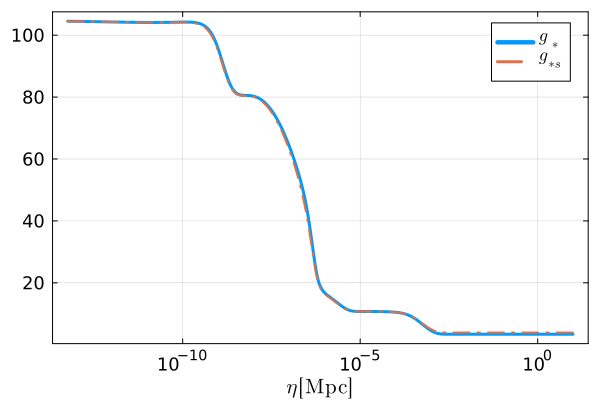

In [13]:
plot(grhoint, etaList, xscale=:log10, label=L"$g_*$", xlabel=L"$\eta\,[\mathrm{Mpc}]$", legend=true)
plot!(gsint, etaList, label=L"$g_{*s}$", linewidth=:2, linestyle=:auto)

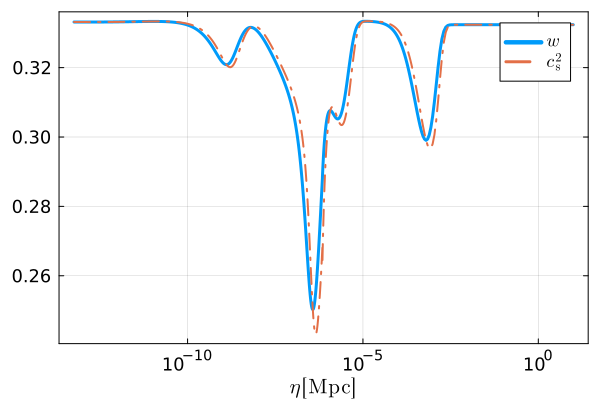

In [14]:
plot(EoSwint, etaList, xscale=:log10, label=L"$w$", xlabel=L"$\eta\,[\mathrm{Mpc}]$", legend=true)
plot!(cs2int, etaList, label=L"$c_\mathrm{s}^2$", linewidth=:2, linestyle=:auto)

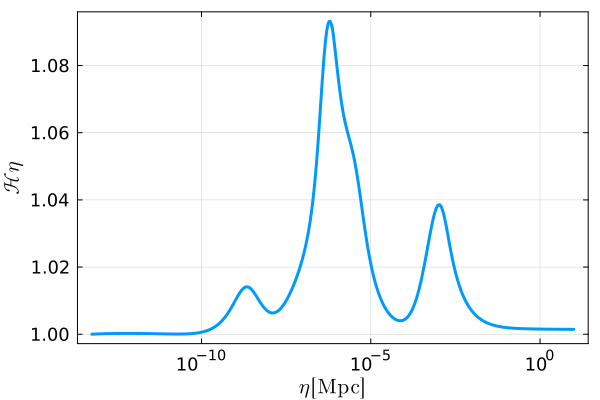

In [15]:
plot(etaList, map(x -> x*calHint(x), etaList), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\mathcal{H}\eta$")

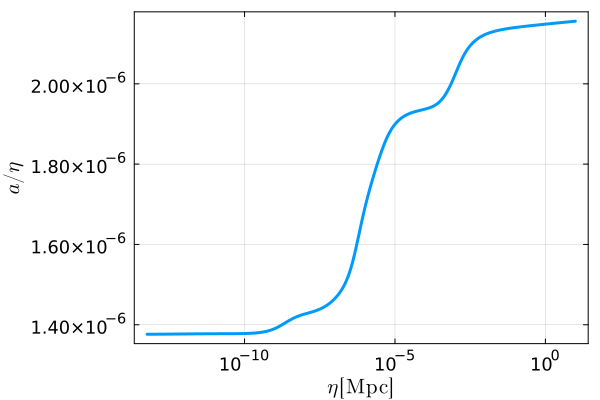

In [16]:
plot(etaList, map(x -> aint(x)/x, etaList), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$a/\eta$")

# kGW = 1e4, ks = 1e9

## calculation

In [21]:
kGW = 1e4;
ks = 1e9;

xi = 1e-2; # initial time in terms of x = k\eta 
xfGW = 1e3;
xfs = 1e7; #xfGW*ks/kGW; # final time in terms of x = k\eta

PhiRD1(x) = 9/x^2 * (sin(x/sqrt(3))/(x/sqrt(3)) - cos(x/sqrt(3))); # Phi in exact RD
PhipRD1(x) = ForwardDiff.derivative(PhiRD1,x); # their x derivatives

g1RD(x) = cos(x); # 2 independent sols. in exact RD
g1pRD(x) = -sin(x);
g2RD(x) = sin(x);
g2pRD(x) = cos(x);

diff(k,eta) = 3*calHint(eta)*(1+cs2int(eta))/k - 4/k/eta;
wsk2(k,eta) = (cs2int(eta) + 3*calHint(eta)^2*(cs2int(eta) - EoSwint(eta))/k^2
    - 6*calHint(eta)*(1+cs2int(eta))/k/k/eta +6/(k*eta)^2 );
#wsk2(k,eta) = cs2int(eta) + 3*calHint(eta)^2/k^2*(cs2int(eta) - EoSwint(eta)); # effective freq. squared

function scalarEoM(du,u,p,x) # u[1] = x^2 Phi, u[2] = d(x^2 Phi)/dx, p = ks
    eta = x/p
    du[1] = u[2]
    du[2] = - diff(p,eta)*u[2] - wsk2(p,eta)*u[1]
end;

function gkEoM(du,u,p,x) # u[1] = g, u[2] = dgdx, p=kGW
    du[1] = u[2]
    du[2] = - (1 - (1-3*EoSwint(x/p))/2*calHint(x/p)^2/p^2)*u[1]
end;

#uis = [Float64(PhiRD1(big(xi))), Float64(PhipRD1(big(xi)))];
uis = [xi^2*PhiRD1(xi), xi^2*PhipRD1(xi) + 2*xi*PhiRD1(xi)];
xspans = (xi,xfs);

ui1 = [g1RD(xi), g1pRD(xi)];
ui2 = [g2RD(xi), g2pRD(xi)];
xspanGW = (xi,xfGW);

scalarprob = ODEProblem(scalarEoM,uis,xspans,ks);
g1prob = ODEProblem(gkEoM,ui1,xspanGW,kGW);
g2prob = ODEProblem(gkEoM,ui2,xspanGW,kGW);

In [23]:
@time scalarsol = solve(scalarprob,Tsit5(), reltol=1e-8,abstol=1e-8,
    maxiters=1_000_000_000);
@time writedlm("data/scalar_1e9.csv", 
    vcat(hcat(scalarsol.t...),hcat(scalarsol.u...)), ',');

2133.088316 seconds (20.43 G allocations: 341.065 GiB, 14.13% gc time, 0.04% compilation time)
263.018724 seconds (851.11 M allocations: 118.505 GiB, 44.36% gc time, 2.30% compilation time)


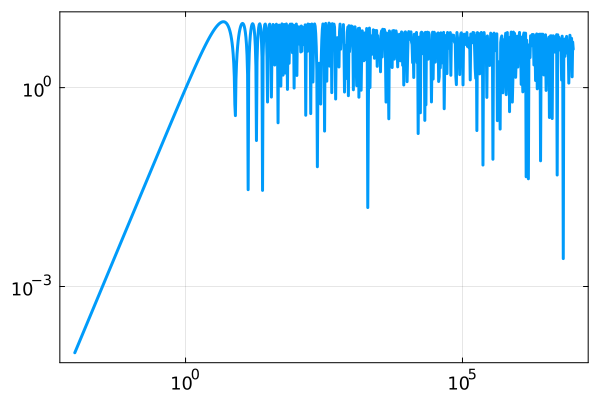

In [24]:
dlnx = 0.01;
xlist = [10^lnx for lnx in log10(xi):dlnx:log10(xfs)];
plot(xlist, x -> abs.(scalarsol(x)[1]), xscale=:log10, yscale=:log10)

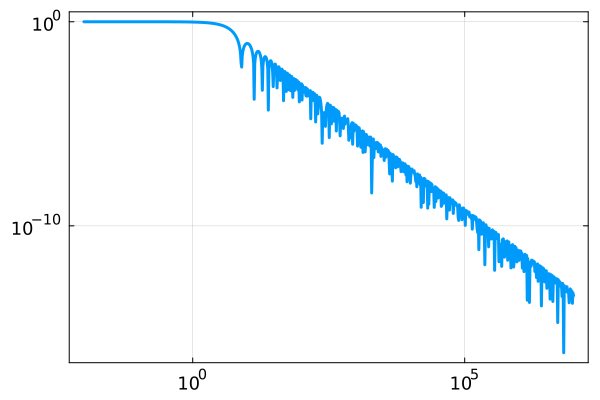

In [29]:
plot(xlist, x -> abs.(scalarsol(x)[1]/x^2), xscale=:log10, yscale=:log10)

In [20]:
@time g1sol = solve(g1prob,Tsit5(),reltol=1e-10,abstol=1e-10);
@time g2sol = solve(g2prob,Tsit5(),reltol=1e-10,abstol=1e-10);
writedlm("data/g1_1e4.csv", vcat(hcat(g1sol.t...),hcat(g1sol.u...)), ',');
writedlm("data/g2_1e4.csv", vcat(hcat(g2sol.t...),hcat(g2sol.u...)), ',');

  0.438489 seconds (3.85 M allocations: 94.309 MiB, 19.68% gc time, 24.40% compilation time)
  0.225943 seconds (2.87 M allocations: 56.614 MiB, 7.03% gc time)


## load

In [87]:
kGW = 1e4;
ks = 1e9;

xi = 1e-2; # initial time in terms of x = k\eta 
xfGW = 1e3;
xfs = 1e7; #xfGW*ks/kGW; # final time in terms of x = k\eta

PhiRD1(x) = 9/x^2 * (sin(x/sqrt(3))/(x/sqrt(3)) - cos(x/sqrt(3))); # Phi in exact RD
PhiRD2(x) = 9/x^2 * (cos(x/sqrt(3))/(x/sqrt(3)) + sin(x/sqrt(3))); # the other independent sol.
PhipRD1(x) = ForwardDiff.derivative(PhiRD1,x); # their x derivatives
PhipRD2(x) = ForwardDiff.derivative(PhiRD2,x);
MPhi(x) = [PhiRD1(x) PhiRD2(x); PhipRD1(x) PhipRD2(x)];

g1RD(x) = cos(x); # 2 independent sols. in exact RD
g1pRD(x) = -sin(x);
g2RD(x) = sin(x);
g2pRD(x) = cos(x);
Mg(x) = [g1RD(x) g2RD(x); g1pRD(x) g2pRD(x)];

In [23]:
@time begin
    scalardata = readdlm("data/scalar_1e9.csv", ',');
    g1data = readdlm("data/g1_1e4.csv", ',');
    g2data = readdlm("data/g2_1e4.csv", ',');
end

 38.490541 seconds (710.31 M allocations: 27.127 GiB, 6.61% gc time)


3×26526 Matrix{Float64}:
 0.01        0.0105853  0.0108441  …  999.933     999.972     1000.0
 0.00999983  0.0105859  0.0108455       0.828817    0.854475     0.871702
 0.99995     1.00257    1.00366         0.670935    0.637938     0.614189

In [24]:
@time begin
xsList = scalardata[1,:];
PhiList = scalardata[2,:];
PiList = scalardata[3,:];

PhiCSI = Spline1D(xsList,PhiList);
PiCSI = Spline1D(xsList,PiList);

xGWList1 = g1data[1,:];
g1List = g1data[2,:];
g1pList = g1data[3,:];
xGWList2 = g2data[1,:];
g2List = g2data[2,:];
g2pList = g2data[3,:];

g1int = Spline1D(xGWList1, g1List);
g1pint = Spline1D(xGWList1, g1pList);
g2int = Spline1D(xGWList2, g2List);
g2pint = Spline1D(xGWList2, g2pList);
end

 13.557834 seconds (3.01 k allocations: 27.495 GiB, 2.42% gc time, 0.05% compilation time)


Spline1D(knots=[0.01,0.0108441 … 999.933,1000.0] (26524 elements), k=3, extrapolation="nearest", residual=0.0)

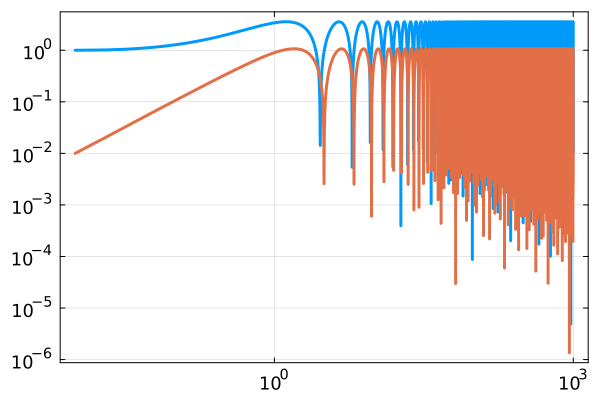

In [25]:
plot(xi:0.01:xfGW, x->abs(g1int(x)), xscale=:log10, yscale=:log10)
plot!(xi:0.01:xfGW, x->abs(g2int(x)), xscale=:log10, yscale=:log10)

In [26]:
# solve Phi and Pi = Phi' on a general b.g. up to xc.
# for x > xc, RD sol. will be used where Phic and Pic are adopted as the initial condition at xc
PhiRDc(x,xc,Phic,Pic) = (MPhi(x)*inv(MPhi(xc))*[Phic,Pic])[1]; 
PhipRDc(x,xc,Phic,Pic) = (MPhi(x)*inv(MPhi(xc))*[Phic,Pic])[2];

# interpolation
# RD sol. in the superH limit for x < xi
# num. sol. for xi <= x <= xf
# RD sol. extrapolating the num. sol. for x > xf
function Phiint(x,xc) 
    if x < xi
        return PhiRD1(x)
    elseif x > xc
        return PhiRDc(x,xc, PhiCSI(xc)/xc^2, PiCSI(xc)/xc^2 - 2*PhiCSI(xc)/xc^3)
    else 
        return PhiCSI(x)/x^2
    end
end;

function Piint(x,xc) 
    if x < xi
        return PhipRD1(x)
    elseif x > xc
        return PhipRDc(x,xc, PhiCSI(xc)/xc^2, PiCSI(xc)/xc^2 - 2*PhiCSI(xc)/xc^3)
    else 
        return PiCSI(x)/x^2 - 2*PhiCSI(x)/x^3
    end
end;

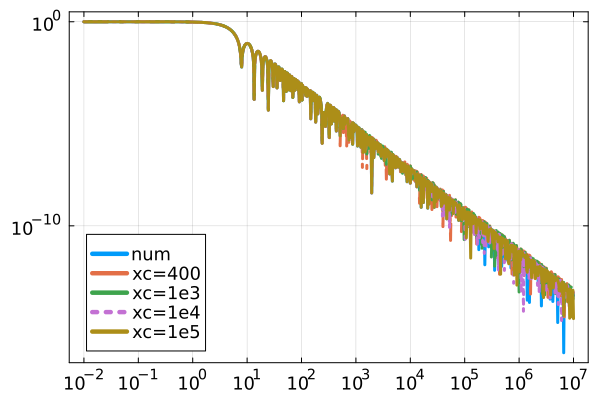

In [27]:
xlist = [10^lnx for lnx in log10(xi):0.01:log10(xfs)];

plot(xlist, x -> abs(Phiint(x,xfs)), yscale=:log10, xscale=:log10, 
    legend=:bottomleft, label="num", xticks=[1e-2,1e-1,1,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8])
plot!(xlist, x -> abs(Phiint(x,400)), linestyle=:auto, label="xc=400")
plot!(xlist, x -> abs(Phiint(x,1e3)), linestyle=:auto, label="xc=1e3")
plot!(xlist, x -> abs(Phiint(x,1e4)), linestyle=:auto, label="xc=1e4")
plot!(xlist, x -> abs(Phiint(x,1e5)), linestyle=:auto, label="xc=1e5")

In [45]:
savefig("Phi_1e9_err.pdf")

"/Users/yuichirotada/Documents/Univ/SIGW_QCD/math/YT/Phi_1e9_err.pdf"

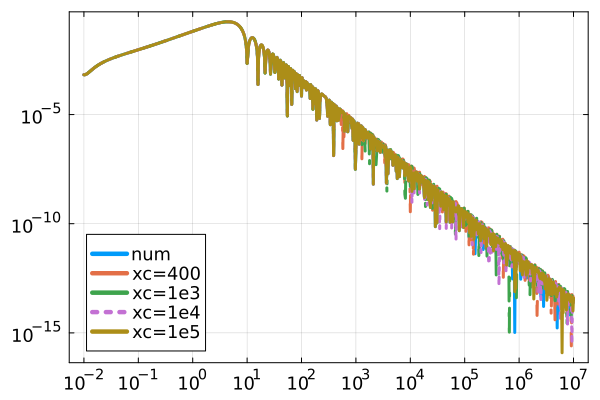

In [28]:
plot(xlist, x -> abs(Piint(x,xfs)), yscale=:log10, xscale=:log10, 
    legend=:bottomleft, label="num", xticks=[1e-2,1e-1,1,10,1e2,1e3,1e4,1e5,1e6,1e7,1e8])
plot!(xlist, x -> abs(Piint(x,400)), linestyle=:auto, label="xc=400")
plot!(xlist, x -> abs(Piint(x,1e3)), linestyle=:auto, label="xc=1e3")
plot!(xlist, x -> abs(Piint(x,1e4)), linestyle=:auto, label="xc=1e4")
plot!(xlist, x -> abs(Piint(x,1e5)), linestyle=:auto, label="xc=1e5")

In [41]:
function calI1(xp,xc)
    xs = ks/kGW*xp
    eta = xp/kGW
    return (4/9*aint(eta)/aint(100/kGW)*g1int(xp) * (2*Phiint(xs,xc)^2
            + 4/3/(1+EoSwint(eta))*(Phiint(xs,xc)+Piint(xs,xc)*ks/calHint(eta))^2))
end;

function calI2(xp,xc)
    xs = ks/kGW*xp
    eta = xp/kGW
    return (4/9*aint(eta)/aint(100/kGW)*g2int(xp) * (2*Phiint(xs,xc)^2
            + 4/3/(1+EoSwint(eta))*(Phiint(xs,xc)+Piint(xs,xc)*ks/calHint(eta))^2))
end;

function I1(x,xc)
    return -quadgk(xp -> calI1(xp,xc),xi,x; maxevals=1e5,rtol=1e-3 #,atol=1e-15)[1]
        )[1]
end;

function I2(x,xc)
    return -quadgk(xp -> calI2(xp,xc),xi,x; maxevals=1e5,rtol=1e-3 #,atol=1e-15)[1]
        )[1]
end;

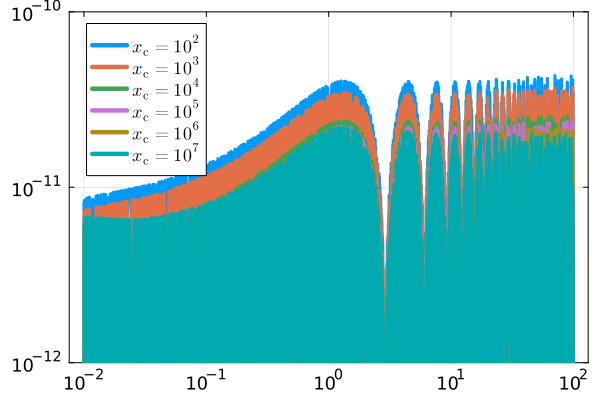

In [85]:
xlist = [10^lnx for lnx in -2:1e-3:2]
plot(xlist, x -> x*abs(calI1(x,1e2)), xscale=:log10, yscale=:log10, ylims=[1e-12,1e-10], 
    legend=:topleft, label=L"$x_\mathrm{c}=10^2$")
plot!(xlist, x -> x*abs(calI1(x,1e3)), label=L"$x_\mathrm{c}=10^3$")
plot!(xlist, x -> x*abs(calI1(x,1e4)), label=L"$x_\mathrm{c}=10^4$")
plot!(xlist, x -> x*abs(calI1(x,1e5)), label=L"$x_\mathrm{c}=10^5$")
plot!(xlist, x -> x*abs(calI1(x,1e6)), label=L"$x_\mathrm{c}=10^6$")
plot!(xlist, x -> x*abs(calI1(x,1e7)), label=L"$x_\mathrm{c}=10^7$")

In [87]:
savefig("I1_integrand.pdf")

"/Users/yuichirotada/Documents/Univ/SIGW_QCD/math/YT/I1_integrand.pdf"

In [97]:
# maxevals = 1e2
@time (I1(1e2,1e7), I2(1e2,1e7)) 

  6.980554 seconds (149.82 k allocations: 6.842 MiB, 1.04% compilation time)


(-3.290625611706964e-11, -4.055939098572246e-12)

In [73]:
# maxevals = 1e3
@time (I1(1e2,1e7), I2(1e2,1e7))

 31.679798 seconds (252.60 k allocations: 8.419 MiB, 0.22% compilation time)


(-3.0705456448202836e-11, -4.504117735893222e-12)

In [77]:
# maxevals = 1e4
@time (I1(1e2,1e7), I2(1e2,1e7))

370.303359 seconds (1.28 M allocations: 24.262 MiB, 0.02% compilation time)


(-2.8834322560990372e-11, -4.777110616097346e-12)

In [93]:
# maxevals = 1e5
@time (I1(1e2,1e7), I2(1e2,1e7))

4549.988809 seconds (11.57 M allocations: 181.946 MiB, 0.00% compilation time)


(-2.8452715388665186e-11, -5.1133875250098224e-12)

In [37]:
xlist1e7 = [10^lnx for lnx in range(-2,2,20)];

In [43]:
I1ListC1e7 = zeros(length(xlist1e7))
I2ListC1e7 = zeros(length(xlist1e7))

@time Threads.@threads for i in 1:length(xlist1e7)
    I1ListC1e7[i] = I1(xlist1e7[i],1e7)
    I2ListC1e7[i] = I2(xlist1e7[i],1e7)
end

6035.291837 seconds (155.46 M allocations: 2.504 GiB, 0.03% gc time, 0.12% compilation time)


In [44]:
writedlm("data/I_1e4_1e9_NC.csv", hcat(I1ListC1e7,I2ListC1e7));

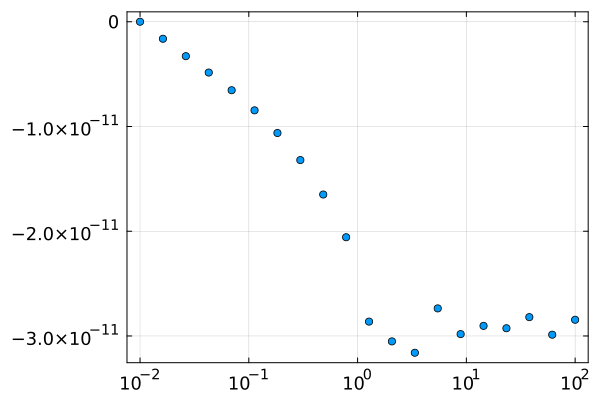

In [45]:
plot(xlist1e7, I1ListC1e7, st=:scatter, xscale=:log10)

In [175]:
coeffA(a,x) = (2+(a^2-1)*x^2)/x^3
coeffB(a,x) = (6+(a^2-1)*x^2)/x^3
coeffC(a,b,x) = (6-(1+2*a^2-b^2)*x^2)/x^4

ic1(d,s,x) = 4/9*288/(s^2-d^2)^3 * ((coeffA(s,x)*cos(x)+coeffC(d,s,x)*sin(x))*cos(d*x) 
    - (coeffA(d,x)*cos(x)+coeffC(s,d,x)*sin(x))*cos(s*x) 
    + (2/x^2*cos(x)+coeffB(s,x)*sin(x))*d*sin(d*x)
    - (2/x^2*cos(x)+coeffB(d,x)*sin(x))*s*sin(s*x)
    + 1/8*(s^2+d^2-2)^2*(sinint((1-s)*x) + sinint((1+s)*x) 
        - sinint((1+d)*x) - sinint((1-d)*x)) *100/kGW
)

is1(d,s,x) = 4/9*288/(s^2-d^2)^3 * (-(coeffA(s,x)*sin(x)+coeffC(d,s,x)*cos(x))*cos(d*x) 
    - (-coeffA(d,x)*sin(x)+coeffC(s,d,x)*cos(x))*cos(s*x) 
    + (-2/x^2*sin(x)+coeffB(s,x)*cos(x))*d*sin(d*x)
    - (-2/x^2*sin(x)+coeffB(d,x)*cos(x))*s*sin(s*x)
    + 1/8*(s^2+d^2-2)^2*(cosint(abs(1-s)*x) + cosint((1+s)*x) 
        - cosint((1+d)*x) - cosint((1-d)*x)) *100/kGW
)

ic2(d,s,x) = 4/9*288/(s^2-d^2)^3 * ((coeffA(s,x)*cos(x)+coeffC(d,s,x)*sin(x))*cos(d*x) 
    + (coeffA(d,x)*cos(x)+coeffC(s,d,x)*sin(x))*cos(s*x) 
    + (2/x^2*cos(x)+coeffB(s,x)*sin(x))*d*sin(d*x)
    + (2/x^2*cos(x)+coeffB(d,x)*sin(x))*s*sin(s*x)
    - 1/8*(s^2+d^2-2)^2*(sinint((1-d)*x) + sinint((1+d)*x) 
        + sinint((1+s)*x) + sinint((1-s)*x)) *100/kGW
)

is2(d,s,x) = 4/9*288/(s^2-d^2)^3 * ((coeffA(s,x)*sin(x)-coeffC(d,s,x)*cos(x))*cos(d*x) 
    + (coeffA(d,x)*sin(x)-coeffC(s,d,x)*cos(x))*cos(s*x) 
    + (2/x^2*sin(x)-coeffB(s,x)*cos(x))*d*sin(d*x)
    + (2/x^2*sin(x)-coeffB(d,x)*cos(x))*s*sin(s*x)
    + 1/8*(s^2+d^2-2)^2*(cosint(abs(1-s)*x) + cosint((1+s)*x) 
        + cosint((1+d)*x) + cosint((1-d)*x)) *100/kGW
)

function dI1(x,xc) 
    S1, S2 = inv(MPhi(xc))*[Phiint(xc,1e7),Piint(xc,1e7)]
    T1, T2 = inv(Mg(xc))*[g1int(xc),g1pint(xc)]

    return T1*S1^2*(ic1(0,2*ks/kGW/sqrt(3),x) - ic1(0,2*ks/kGW/sqrt(3),xc)) +
        T1*S2^2*(ic2(0,2*ks/kGW/sqrt(3),x) - ic2(0,2*ks/kGW/sqrt(3),xc)) +
        T2*S1^2*(is1(0,2*ks/kGW/sqrt(3),x) - is1(0,2*ks/kGW/sqrt(3),xc)) +
        T2*S2^2*(is2(0,2*ks/kGW/sqrt(3),x) - is2(0,2*ks/kGW/sqrt(3),xc))
end

dI1 (generic function with 1 method)

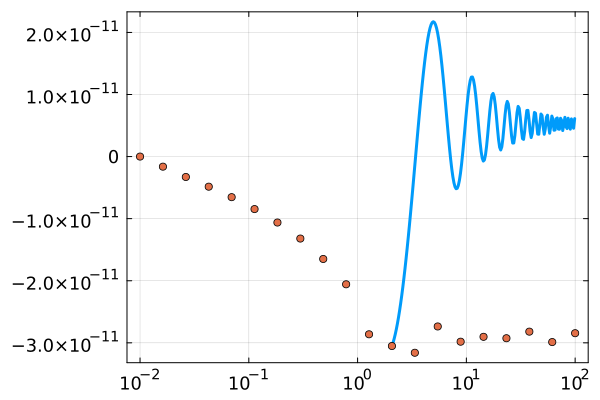

In [177]:
iconnect = 12
plot([10^lnx for lnx in log10(xlist1e7[iconnect]):0.01:2], 
    x -> dI1(x,xlist1e7[iconnect]) + I1ListC1e7[iconnect])
plot!(xlist1e7, I1ListC1e7, xscale=:log10, st=:scatter)

In [105]:
dlnx = 0.01;
xlist400 = [10^lnx for lnx in log10(2xi):dlnx:log10(xfGW)];

In [151]:
I1ListC400 = zeros(length(xlist400))
I2ListC400 = zeros(length(xlist400))

@time Threads.@threads for i in 1:length(xlist400)
    I1ListC400[i] = I1(xlist400[i],400)
    I2ListC400[i] = I2(xlist400[i],400)
end

22205.293177 seconds (392.37 G allocations: 16.696 TiB, 7.06% gc time, 0.00% compilation time)


In [167]:
writedlm("data/I_1e4_1e9_400.csv", hcat(I1ListC400,I2ListC400));

In [101]:
IC400data = readdlm("data/I_1e4_1e9_400.csv");
I1ListC400 = IC400data[:,1];
I2ListC400 = IC400data[:,2];

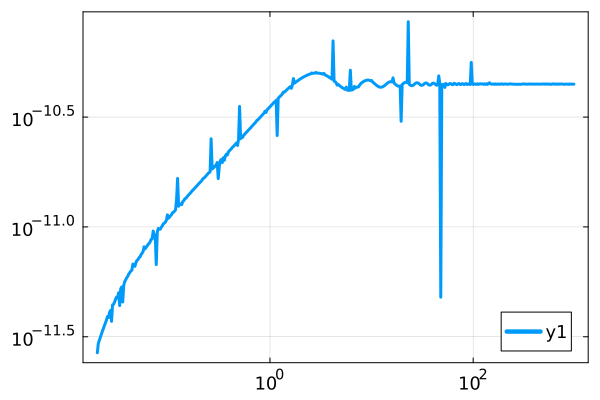

In [165]:
plot(xlist400, abs.(I1ListC400),xscale=:log10,yscale=:log10, legend=:bottomright)

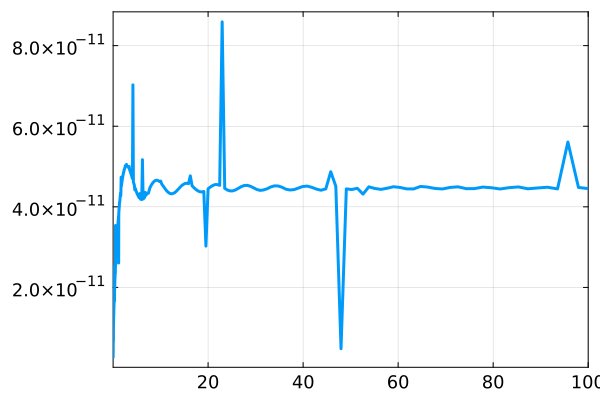

In [109]:
plot(xlist400, abs.(I1ListC400), xlims=[xi,100])

In [57]:
dlnx = 1;
xlist = [10^lnx for lnx in ceil(Int,log10(2xi)):dlnx:log10(xfGW)];

In [59]:
I1ListC1e3 = zeros(length(xlist))
I2ListC1e3 = zeros(length(xlist))

@time Threads.@threads for i in 1:length(xlist)
    I1ListC1e3[i] = I1(xlist[i],1e3)
    I2ListC1e3[i] = I2(xlist[i],1e3)
end

710.654202 seconds (9.43 G allocations: 385.937 GiB, 4.75% gc time, 0.29% compilation time)


In [60]:
I1ListC5e3 = zeros(length(xlist))
I2ListC5e3 = zeros(length(xlist))

@time Threads.@threads for i in 1:length(xlist)
    I1ListC5e3[i] = I1(xlist[i],5e3)
    I2ListC5e3[i] = I2(xlist[i],5e3)
end

2571.004394 seconds (9.42 G allocations: 384.903 GiB, 1.36% gc time, 0.00% compilation time)


In [61]:
I1ListC1e4 = zeros(length(xlist))
I2ListC1e4 = zeros(length(xlist))

@time Threads.@threads for i in 1:length(xlist)
    I1ListC1e4[i] = I1(xlist[i],1e4)
    I2ListC1e4[i] = I2(xlist[i],1e4)
end

4864.239501 seconds (9.40 G allocations: 383.581 GiB, 0.82% gc time, 0.00% compilation time)


In [62]:
I1ListC100 = zeros(length(xlist))
I2ListC100 = zeros(length(xlist))

@time Threads.@threads for i in 1:length(xlist)
    I1ListC100[i] = I1(xlist[i],1e2)
    I2ListC100[i] = I2(xlist[i],1e2)
end

308.507705 seconds (9.43 G allocations: 385.852 GiB, 9.73% gc time, 0.03% compilation time)


In [63]:
writedlm("data/I_1e4_1e9_100.csv", hcat(I1ListC100,I2ListC100));
writedlm("data/I_1e4_1e9_1e3.csv", hcat(I1ListC1e3,I2ListC1e3));
writedlm("data/I_1e4_1e9_5e3.csv", hcat(I1ListC5e3,I2ListC5e3));
writedlm("data/I_1e4_1e9_1e4.csv", hcat(I1ListC1e4,I2ListC1e4));

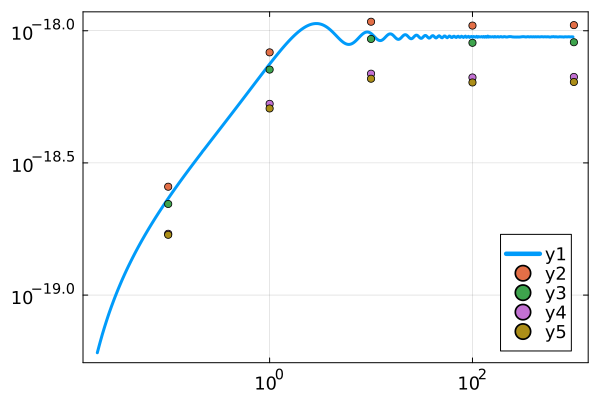

In [64]:
plot(xlist400, [aint(xlist400[i]/kGW)*abs(I1ListC400[i]) for i in 1:length(xlist400)],
    xscale=:log10,yscale=:log10, legend=:bottomright)
plot!(xlist, [aint(xlist[i]/kGW)*abs(I1ListC100[i]) for i in 1:length(xlist)], st=:scatter)
plot!(xlist, [aint(xlist[i]/kGW)*abs(I1ListC1e3[i]) for i in 1:length(xlist)], st=:scatter)
plot!(xlist, [aint(xlist[i]/kGW)*abs(I1ListC5e3[i]) for i in 1:length(xlist)], st=:scatter)
plot!(xlist, [aint(xlist[i]/kGW)*abs(I1ListC1e4[i]) for i in 1:length(xlist)], st=:scatter)

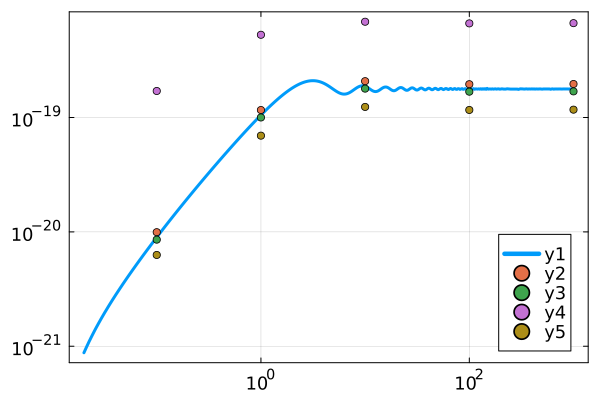

In [65]:
plot(xlist400, [aint(xlist400[i]/kGW)*abs(I2ListC400[i]) for i in 1:length(xlist400)],
    xscale=:log10,yscale=:log10, legend=:bottomright)
plot!(xlist, [aint(xlist[i]/kGW)*abs(I2ListC100[i]) for i in 1:length(xlist)], st=:scatter)
plot!(xlist, [aint(xlist[i]/kGW)*abs(I2ListC1e3[i]) for i in 1:length(xlist)], st=:scatter)
plot!(xlist, [aint(xlist[i]/kGW)*abs(I1ListC5e3[i]) for i in 1:length(xlist)], st=:scatter)
plot!(xlist, [aint(xlist[i]/kGW)*abs(I2ListC1e4[i]) for i in 1:length(xlist)], st=:scatter)

In [ ]:
dlnxc = 0.01;
xclist = [10^lnxc for lnxc in 2:dlnxc:4];

I1Listxc = zeros(length(xclist))
I2Listxc = zeros(length(xclist))

@time Threads.@threads for i in 1:length(xclist)
    I1Listxc[i] = I1(100,xclist[i])
    I2Listxc[i] = I2(100,xclist[i])
end

In [ ]:
plot(xclist, I1Listxc, xscale=:log10)

In [ ]:
plot(xclist, I2Listxc, xscale=:log10)

In [53]:
writedlm("data/Ixc.csv", hcat(I1Listxc,I2Listxc));